# Week 4. Training Issues
In this part, we will formally set up a simple but powerful classification network, to recogize 0-9 nubmers in MNIST dataset.    

Yep, we will build a classification network and train from scratch. 

We would introduce some techniques to improve your train model performance.

This part is designed and completed by **Jiaxin Zhuang( zhuangjx5@mail2.sysu.edu.cn )** and Feifei Xue(xueff@mail2.sysu.edu.cn), if you have some questions about this part and you think there are still some things to do, dont't hesitate to email us or add our wechat.  

# Outline

1. Outline
    1. Required modules ( If you use your own computer, Just pip install it ! )
    2. Common Setup
2. classificatioon network
    1. short introdution of MNIST 
    2. Define a Feedforward Neural network
3. Training 
    0. Including that define a model, loss function, metric, data-augmentation for training data
    1. Pre-set hyper-parameters
    2. Initialize model parameters
    3. repeat over certain number of epochs
        1. Shuffle whole training data
        2. For each mini-batch data
            1. load mini-batch data
            2. compute gradient of loss over parameters
            3. update parameters with gradient descent
    4. save model
4. Training advanced
    1. l2\_norm
    2. dropout
    3. batch_normalization
    4. data augmentation
5. Visualizatio of training and validation phase
    1. add tensorboardX to writer summary into tensorboard
    2. download your file in local
    3. run tensorboard in pc and open http://localhost:6666 to browse the tensorboard
6. Gradient 
    1. Gradient vanishing
    2. Gradient exploding

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1.1 Required Module

[numpy](https://docs.scipy.org/doc/numpy-1.13.0/user/whatisnumpy.html): NumPy is the fundamental package for scientific computing in Python.

[pytorch](https://pytorch.org/docs/stable/index.html): End-to-end deep learning platform.

[torchvision](https://pytorch.org/docs/stable/torchvision/index.html): This package consists of popular datasets, model architectures, and common image transformations for computer vision.

[tensorflow](https://www.tensorflow.org/guide): An open source machine learning framework.

[tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard): A suite of visualization tools to make training easier to understand, debug, and optimize TensorFlow programs.

[tensorboardX](https://tensorboardx.readthedocs.io/en/latest/tensorboard.html): Tensorboard for Pytorch.

[matplotlib](https://matplotlib.org/): It is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

# 1.2 Common Setup

In [3]:
# Load all necessary modules here, for clearness
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision.datasets import MNIST
import torchvision
from torchvision import transforms
from torch.optim import lr_scheduler
# from tensorboardX import SummaryWriter
from collections import OrderedDict
import matplotlib.pyplot as plt
# from tqdm import tqdm

In [4]:
# Whether to put data in GPU according to GPU is available or not 
# cuda = torch.cuda.is_available() 
#  In case the default gpu does not have enough space, you can choose which device to use
# torch.cuda.set_device(device) # device: id

# Since gpu in lab is not enough for your guys, we prefer to cpu computation
cuda = torch.device('cpu') 

# 2. Classfication Model
Ww would define a simple Convolutional Neural Network to classify MNIST

## 2.1 Short indroduction of MNIST
The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. 

The MNIST database contains 60,000 training images and 10,000 testing images. Each class has 5000 traning images and 1000 test images. 

Each image is 28x28.

And they look like images below.

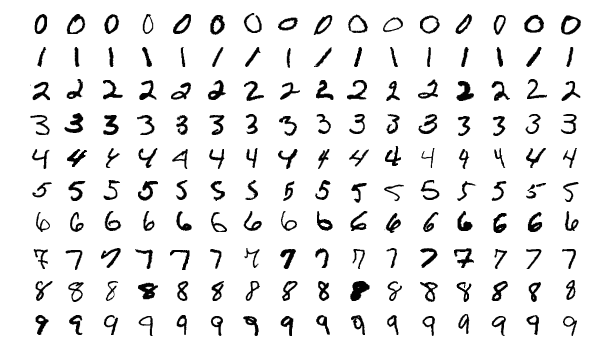

# 2.2 Define A FeedForward Neural Network 
We would fefine a FeedForward Neural Network with **3 hidden layers**. 

Each layer is followed a activation function, we would try **sigmoid** and **relu** respectively. 

For simplicity, each hidden layer has the equal neurons. 

In reality, however, we would apply different amount of neurons in different hidden layers.

## 2.2.1 Activation Function
There are many useful activation function and you can choose one of them to use. Usually we use **relu** as our network function.

#### 2.2.1.1 ReLU
Applies the rectified linear unit function element-wise

\begin{equation}
    ReLU(x) = max(0, x)
\end{equation}

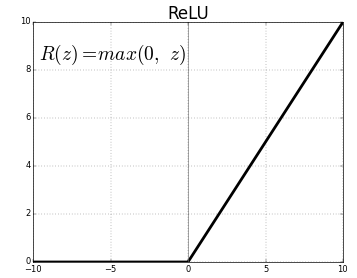

#### 2.2.1.2 Sigmoid
Applies the element-wise function:

\begin{equation}
Sigmoid(x)=\frac{1}{1+e^{-x}}    
\end{equation}
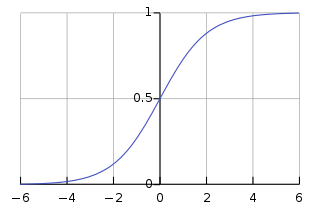

## 2.2.2 Network's Input and output
Inputs: For every batch 
>\[batchSize, channels, height, width\] -> [B,C,H,W]

Outputs: prediction scores of each images, eg. \[0.001, 0.0034 ..., 0.3\]
> \[batchSize, classes\]

Network Strutrue

```
    Inputs                Linear/Function        Output
    [128, 1, 28, 28]   -> Linear(28*28, 100) -> [128, 100]  # first hidden lyaer
                       -> ReLU               -> [128, 100]  # relu activation function, may sigmoid
                       -> Linear(100, 100)   -> [128, 100]  # second hidden lyaer
                       -> ReLU               -> [128, 100]  # relu activation function, may sigmoid
                       -> Linear(100, 100)   -> [128, 100]  # third hidden lyaer
                       -> ReLU               -> [128, 100]  # relu activation function, may sigmoid
                       -> Linear(100, 10)    -> [128, 10]   # Classification Layer                                                          
```

In [5]:
class FeedForwardNeuralNetwork(nn.Module):
    """
    Inputs                Linear/Function        Output
    [128, 1, 28, 28]   -> Linear(28*28, 100) -> [128, 100]  # first hidden lyaer
                       -> ReLU               -> [128, 100]  # relu activation function, may sigmoid
                       -> Linear(100, 100)   -> [128, 100]  # second hidden lyaer
                       -> ReLU               -> [128, 100]  # relu activation function, may sigmoid
                       -> Linear(100, 100)   -> [128, 100]  # third hidden lyaer
                       -> ReLU               -> [128, 100]  # relu activation function, may sigmoid
                       -> Linear(100, 10)    -> [128, 10]   # Classification Layer                                                          
   """
    def __init__(self, input_size, hidden_size, output_size, activation_function='RELU'):
        super(FeedForwardNeuralNetwork, self).__init__()
        self.use_dropout = False
        self.use_bn = False
        self.hidden1 = nn.Linear(input_size, hidden_size)  # Linear function 1: 784 --> 100 
        self.hidden2 = nn.Linear(hidden_size, hidden_size) # Linear function 2: 100 --> 100
        self.hidden3 = nn.Linear(hidden_size, hidden_size) # Linear function 3: 100 --> 100
        # Linear function 4 (readout): 100 --> 10
        self.classification_layer = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=0.5) # Drop out with prob = 0.5
        self.hidden1_bn = nn.BatchNorm1d(hidden_size) # Batch Normalization 
        self.hidden2_bn = nn.BatchNorm1d(hidden_size)
        self.hidden3_bn = nn.BatchNorm1d(hidden_size)
        
        # Non-linearity
        if activation_function == 'SIGMOID':
            self.activation_function1 = nn.Sigmoid()
            self.activation_function2 = nn.Sigmoid()
            self.activation_function3 = nn.Sigmoid()
        elif activation_function == 'RELU':
            self.activation_function1 = nn.ReLU()
            self.activation_function2 = nn.ReLU()
            self.activation_function3 = nn.ReLU()
        
    def forward(self, x):
        """Defines the computation performed at every call.
           Should be overridden by all subclasses.
        Args:
            x: [batch_size, channel, height, width], input for network
        Returns:
            out: [batch_size, n_classes], output from network
        """
        
        x = x.view(x.size(0), -1) # flatten x in [128, 784]
        out = self.hidden1(x)
        out = self.activation_function1(out) # Non-linearity 1
        if self.use_bn == True:
            out = self.hidden1_bn(out)
        out = self.hidden2(out)
        out = self.activation_function2(out)
        if self.use_bn == True:
            out = self.hidden2_bn(out)
        out = self.hidden3(out)
        if self.use_bn == True:
            out = self.hidden3_bn(out)
        out = self.activation_function3(out)
        if self.use_dropout == True:
            out = self.dropout(out)
        out = self.classification_layer(out)
        return out
    
    def set_use_dropout(self, use_dropout):
        """Whether to use dropout. Auxiliary function for our exp, not necessary.
        Args:
            use_dropout: True, False
        """
        self.use_dropout = use_dropout
        
    def set_use_bn(self, use_bn):
        """Whether to use batch normalization. Auxiliary function for our exp, not necessary.
        Args:
            use_bn: True, False
        """
        self.use_bn = use_bn
        
    def get_grad(self):
        """Return average grad for hidden2, hidden3. Auxiliary function for our exp, not necessary.
        """
        hidden2_average_grad = np.mean(np.sqrt(np.square(self.hidden2.weight.grad.detach().numpy())))
        hidden3_average_grad = np.mean(np.sqrt(np.square(self.hidden3.weight.grad.detach().numpy())))
        return hidden2_average_grad, hidden3_average_grad

# 3. Training 
We would define training function here. Additionally, hyper-parameters, loss function, metric would be included here too. 

## 3.1 Pre-set hyper-parameters
setting hyperparameters like below

hyper paprameters include following part

* learning rate: usually we start from a quite bigger lr like 1e-1, 1e-2, 1e-3, and slow lr as epoch moves.
* n_epochs: training epoch must set large so model has enough time to converge. Usually, we will set a quite big epoch at the first training time.  
* batch_size: usually, bigger batch size mean's better usage of GPU and model would need less epoches to converge. And the exponent of 2 is used, eg. 2, 4, 8, 16, 32, 64, 128. 256.  

In [6]:
### Hyper parameters

batch_size = 128 # batch size is 128
n_epochs = 5 # train for 5 epochs
learning_rate = 0.01 # learning rate is 0.01
input_size = 28*28 # input image has size 28x28
hidden_size = 100 # hidden neurons is 100 for each layer
output_size = 10 # classes of prediction
l2_norm = 0 # not to use l2 penalty
dropout = False # not to use
get_grad = False # not to obtain grad

In [7]:
# create a model object
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_norm) 

## 3.2 Initialize model parameters
Pytorch provide default initialization (**uniform intialization**) for linear layer. But there is still some useful intialization method.

Read more about initialization from this [link](https://pytorch.org/docs/stable/_modules/torch/nn/init.html)

```
    torch.nn.init.normal_
    torch.nn.init.uniform_
    torch.nn.init.constant_
    torch.nn.init.eye_
    torch.nn.init.xavier_uniform_
    torch.nn.init.xavier_normal_
    torch.nn.init.kaiming_uniform_
```

In [8]:
def show_weight_bias(model):
    """Show some weights and bias distribution every layers in model. 
       !!YOU CAN READ THIS CODE LATER!! 
    """
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(2,3, sharey=False, tight_layout=True)
    
    # weight and bias for every hidden layer
    h1_w = model.hidden1.weight.detach().numpy().flatten()
    h1_b = model.hidden1.bias.detach().numpy().flatten()
    h2_w = model.hidden2.weight.detach().numpy().flatten()
    h2_b = model.hidden2.bias.detach().numpy().flatten()
    h3_w = model.hidden3.weight.detach().numpy().flatten()
    h3_b = model.hidden3.bias.detach().numpy().flatten()
    
    axs[0,0].hist(h1_w)
    axs[0,1].hist(h2_w)
    axs[0,2].hist(h3_w)
    axs[1,0].hist(h1_b)
    axs[1,1].hist(h2_b)
    axs[1,2].hist(h3_b)
    
    # set title for every sub plots
    axs[0,0].set_title('hidden1_weight')
    axs[0,1].set_title('hidden2_weight')
    axs[0,2].set_title('hidden3_weight')
    axs[1,0].set_title('hidden1_bias')
    axs[1,1].set_title('hidden2_bias')
    axs[1,2].set_title('hidden3_bias')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


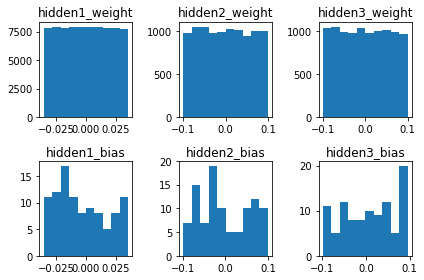

In [9]:
# Show default initialization for every hidden layer by pytorch
# it's uniform distribution 
show_weight_bias(model)

In [20]:
# If you want to use other intialization method, you can use code below
# and define your initialization below

def weight_bias_reset(model):
    """Custom initialization, you can use your favorable initialization method.
    """
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # initialize linear layer with mean and std
            mean, std = 0, 0.1 
            
            # Initialization method
            torch.nn.init.normal_(m.weight, mean, std)
            torch.nn.init.normal_(m.bias, mean, std)
            
#             Another way to initialize
#             m.weight.data.normal_(mean, std)
#             m.bias.data.normal_(mean, std)

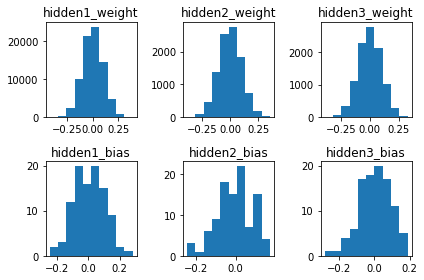

In [21]:
weight_bias_reset(model) # reset parameters for each hidden layer
show_weight_bias(model) # show weight and bias distribution, normal distribution now.

## 作业1
使用 torch.nn.init.constant, torch.nn.init.xavier_uniform_, torch.nn.init_xavier_normal_去重写初始化函数，使用对应函数初始化模型，并且使用show_weight_bias显示模型隐藏层的参数分布。此处应该有6个cell作答。!!不必初始化bias！！

In [22]:
# TODO

def weight_bias_reset_constant(model):
    """Constant initalization
    """
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # remove pass and code here
            val = 0.1
            torch.nn.init.constant_(m.weight, val)

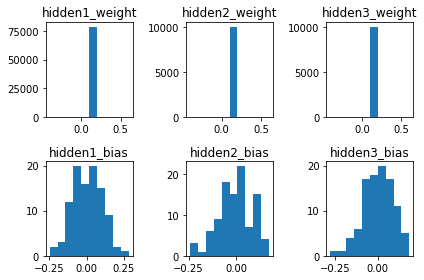

In [23]:
# TODO
weight_bias_reset_constant(model)
show_weight_bias(model)
# Reset parameters and show their distribution

In [24]:
# TODO

def weight_bias_reset_xavier_uniform(model):
    """xaveir_uniform, gain=1
    """
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # remove pass and code here
            gain = 1
            torch.nn.init.xavier_uniform_(m.weight, gain)

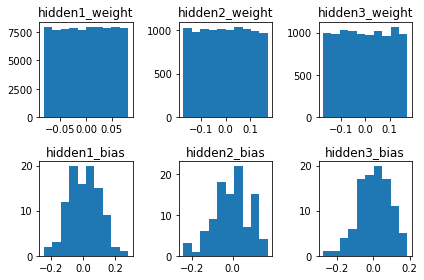

In [25]:
# TODO
weight_bias_reset_xavier_uniform(model)
show_weight_bias(model)
# Reset parameters and show their distribution

In [34]:
# TODO

def weight_bias_reset_kaiming_uniform(model):
    """kaiming_uniform, a=0,model='fan_in', non_linearity='relu'
    """
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # remove pass and code here
            a = 0
            torch.nn.init.kaiming_uniform_(m.weight, a=a, mode='fan_in')

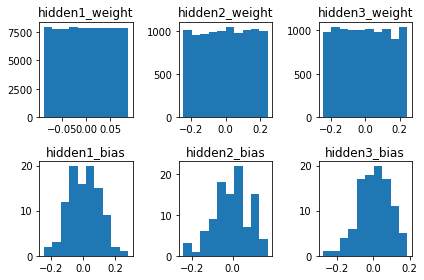

In [35]:
# TODO
weight_bias_reset_kaiming_uniform(model)
show_weight_bias(model)
# Reset parameters and show their distribution

## 3.3 Repeat over certain numbers of epoch

* Shuffle whole training data 

```shuffle
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
```
* For each mini-batch data

    * load mini-batch data
    
    ```
    for batch_idx, (data, target) in enumerate(train_loader): \
        ...
    ```
    
    * compute gradient of loss over parameters
    
    ```
     output = net(data) # make prediction
     loss = loss_fn(output, target)  # compute loss 
     loss.backward() # compute gradient of loss over parameters 
    ```
    
    * update parameters with gradient descent
    
    ```
    optimzer.step() # update parameters with gradient descent 
    ```


### 3.3.1 Shuffle whole traning data

#### 3.3.1.1 Data Loading 
Please pay attention to data augmentation. 

Read more data augmentation method from this [link](https://pytorch.org/docs/stable/torchvision/transforms.html). 

```
torchvision.transforms.RandomVerticalFlip
torchvision.transforms.RandomHorizontalFlip
...
```


In [12]:
# define method of preprocessing data for evaluating

train_transform = transforms.Compose([
    transforms.ToTensor(), # Convert a PIL Image or numpy.ndarray to tensor.
    # Normalize a tensor image with mean 0.1307 and standard deviation 0.3081
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [14]:
# use MNIST provided by torchvision

# torchvision.datasets provide MNIST dataset for classification

train_dataset = torchvision.datasets.MNIST(root='./data', 
                            train=True, 
                            transform=train_transform,
                            download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                           train=False, 
                           transform=test_transform,
                           download=False)

In [15]:
# pay attention to this, train_dataset doesn't load any data
# It just defined some method and store some message to preprocess data
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None

In [16]:
# Data loader. 

# Combines a dataset and a sampler, 
# and provides single- or multi-process iterators over the dataset.

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [17]:
# functions to show an image

def imshow(img):
    """show some imgs in datasets
        !!YOU CAN READ THIS CODE LATER!! """
    
    npimg = img.numpy() # convert tensor to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # [channel, height, width] -> [height, width, channel]
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


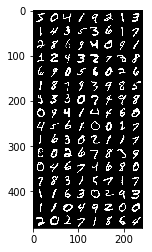

In [18]:
# get some random training images by batch

dataiter = iter(train_loader)
images, labels = dataiter.next() # get a batch of images

# show images
imshow(torchvision.utils.make_grid(images))

### 3.3.2 & 3.3.3 compute gradient of loss over parameters & update parameters with gradient descent

In [19]:
def train(train_loader, model, loss_fn, optimizer, get_grad=False):
    """train model using loss_fn and optimizer. When thid function is called, model trains for one epoch.
    Args:
        train_loader: train data
        model: prediction model
        loss_fn: loss function to judge the distance between target and outputs
        optimizer: optimize the loss function
        get_grad: True, False
    Returns:
        total_loss: loss
        average_grad2: average grad for hidden 2 in this epoch
        average_grad3: average grad for hidden 3 in this epoch
    """
    
    # set the module in training model, affecting module e.g., Dropout, BatchNorm, etc.
    model.train()
    
    total_loss = 0
    grad_2 = 0.0 # store sum(grad) for hidden 3 layer
    grad_3 = 0.0 # store sum(grad) for hidden 3 layer
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clear gradients of all optimized torch.Tensors'
        outputs = model(data) # make predictions 
        loss = loss_fn(outputs, target) # compute loss 
        total_loss += loss.item() # accumulate every batch loss in a epoch
        loss.backward() # compute gradient of loss over parameters 
        
        if get_grad == True:
            g2, g3 = model.get_grad() # get grad for hiddern 2 and 3 layer in this batch
            grad_2 += g2 # accumulate grad for hidden 2
            grad_3 += g3 # accumulate grad for hidden 2
            
        optimizer.step() # update parameters with gradient descent 
            
    average_loss = total_loss / batch_idx # average loss in this epoch
    average_grad2 = grad_2 / batch_idx # average grad for hidden 2 in this epoch
    average_grad3 = grad_3 / batch_idx # average grad for hidden 3 in this epoch
    
    return average_loss, average_grad2, average_grad3

In [20]:
def evaluate(loader, model, loss_fn):
    """test model's prediction performance on loader.  
    When thid function is called, model is evaluated.
    Args:
        loader: data for evaluation
        model: prediction model
        loss_fn: loss function to judge the distance between target and outputs
    Returns:
        total_loss
        accuracy
    """
    
    # context-manager that disabled gradient computation
    with torch.no_grad():
        
        # set the module in evaluation mode
        model.eval()
        
        correct = 0.0 # account correct amount of data
        total_loss = 0  # account loss
        
        for batch_idx, (data, target) in enumerate(loader):
            outputs = model(data) # make predictions 
            # return the maximum value of each row of the input tensor in the 
            # given dimension dim, the second return vale is the index location
            # of each maxium value found(argmax)
            _, predicted = torch.max(outputs, 1)
            # Detach: Returns a new Tensor, detached from the current graph.
            #The result will never require gradient.
            correct += (predicted == target).sum().detach().numpy()
            loss = loss_fn(outputs, target)  # compute loss 
            total_loss += loss.item() # accumulate every batch loss in a epoch
            
        accuracy = correct*100.0 / len(loader.dataset) # accuracy in a epoch
        
    return total_loss, accuracy

Define function fit and use train_epoch and test_epoch

In [21]:
def fit(train_loader, val_loader, model, loss_fn, optimizer, n_epochs, get_grad=False):
    """train and val model here, we use train_epoch to train model and 
    val_epoch to val model prediction performance
    Args: 
        train_loader: train data
        val_loader: validation data
        model: prediction model
        loss_fn: loss function to judge the distance between target and outputs
        optimizer: optimize the loss function
        n_epochs: training epochs
        get_grad: Whether to get grad of hidden2 layer and hidden3 layer
    Returns:
        train_accs: accuracy of train n_epochs, a list
        train_losses: loss of n_epochs, a list
    """
    
    grad_2 = [] # save grad for hidden 2 every epoch
    grad_3 = [] # save grad for hidden 3 every epoch
    
    train_accs = [] # save train accuracy every epoch
    train_losses = [] # save train loss every epoch
    
    for epoch in range(n_epochs): # train for n_epochs 
        # train model on training datasets, optimize loss function and update model parameters 
        train_loss, average_grad2, average_grad3 = train(train_loader, model, loss_fn, optimizer, get_grad)
        
        # evaluate model performance on train dataset
        _, train_accuracy = evaluate(train_loader, model, loss_fn)
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, \
                                                                n_epochs, train_loss, train_accuracy)
        print(message)
    
        # save loss, accuracy, grad
        train_accs.append(train_accuracy)
        train_losses.append(train_loss)
        grad_2.append(average_grad2)
        grad_3.append(average_grad3)
    
        # evaluate model performance on val dataset
        val_loss, val_accuracy = evaluate(val_loader, model, loss_fn)
        message = 'Epoch: {}/{}. Validation set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, \
                                                                n_epochs, val_loss, val_accuracy)
        print(message)
        
        
    # Whether to get grad for showing
    if get_grad == True:
        fig, ax = plt.subplots() # add a set of subplots to this figure
        ax.plot(grad_2, label='Gradient for Hidden 2 Layer') # plot grad 2 
        ax.plot(grad_3, label='Gradient for Hidden 3 Layer') # plot grad 3 
        plt.ylim(top=0.004)
        # place a legend on axes
        legend = ax.legend(loc='best', shadow=True, fontsize='x-large')
    
    return train_accs, train_losses

In [22]:
def show_curve(ys, title):
    """plot curlve for Loss and Accuacy
    
    !!YOU CAN READ THIS LATER, if you are interested
    
    Args:
        ys: loss or acc list
        title: Loss or Accuracy
    """
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} Curve:'.format(title))
    plt.xlabel('Epoch')
    plt.ylabel('{} Value'.format(title))
    plt.show()

## 作业 2
1. 运行一下fit函数，根据结束时候训练集的accuracy，回答：模型是否训练到过拟合。
2. 使用提供的show_curve函数，画出训练的时候loss和accuracy的变化

Hints: 因为jupyter对变量有上下文关系，模型，优化器需要重新声明。可以使用以下代码进行重新定义模型和优化器。注意到此处用的是默认初始化。

In [46]:
### Hyper parameters

batch_size = 128 # batch size is 128
n_epochs = 5 # train for 5 epochs
learning_rate = 0.01 # learning rate is 0.01
input_size = 28*28 # input image has size 28x28
hidden_size = 100 # hidden neurons is 100 for each layer
output_size = 10 # classes of prediction
l2_norm = 0 # not to use l2 penalty
dropout = False # not to use
get_grad = False # not to obtain grad

# declare a model
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_norm) 

In [50]:
train_accs, train_losses = fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, get_grad)

Epoch: 1/5. Train set: Average loss: 0.1723, Accuracy: 95.2183
Epoch: 1/5. Validation set: Average loss: 13.3331, Accuracy: 94.7700
Epoch: 2/5. Train set: Average loss: 0.1613, Accuracy: 95.5383
Epoch: 2/5. Validation set: Average loss: 12.6019, Accuracy: 95.1000
Epoch: 3/5. Train set: Average loss: 0.1514, Accuracy: 95.7717
Epoch: 3/5. Validation set: Average loss: 11.9551, Accuracy: 95.4100
Epoch: 4/5. Train set: Average loss: 0.1426, Accuracy: 96.0167
Epoch: 4/5. Validation set: Average loss: 11.4053, Accuracy: 95.6300
Epoch: 5/5. Train set: Average loss: 0.1346, Accuracy: 96.2150
Epoch: 5/5. Validation set: Average loss: 10.9386, Accuracy: 95.8000


模型没有训练到过拟合，随着epoch的增加，测试数据的损失函数依然在减少，预测准确率在增加。

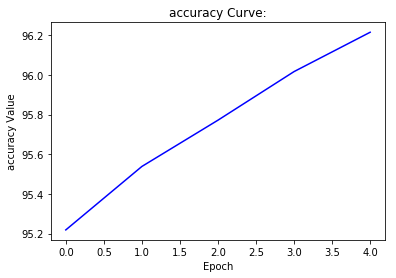

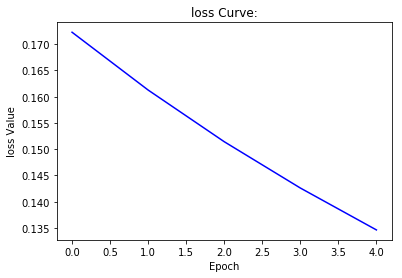

In [53]:
# TODO
show_curve(train_accs, 'accuracy')
show_curve(train_losses, 'loss')
# show curve

## 作业 3
1. 将n_epochs设为10，观察模型是否能在训练集上达到过拟合， 使用show_curve作图。
2. 当希望模型在5个epoch内在训练集上达到过拟合，可以通过适当调整learning rate来实现。选择一个合适的learing rate，训练模型，并且使用show_curve作图， 验证你的learning rate

Hints: 因为jupyter对变量有上下文关系，模型，优化器需要重新声明。可以使用以下代码进行重新定义模型和优化器。注意到此处用的是默认初始化。

In [56]:
### Hyper parameters

batch_size = 128 # batch size is 128
n_epochs = 5 # train for 5 epochs
learning_rate = 0.01 # learning rate is 0.01
input_size = 28*28 # input image has size 28x28
hidden_size = 100 # hidden neurons is 100 for each layer
output_size = 10 # classes of prediction
l2_norm = 0 # not to use l2 penalty
dropout = False # not to use
get_grad = False # not to obtain grad

# declare a model
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_norm) 

In [57]:
# TODO
n_epochs = 10
train_accs, train_losses = fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, get_grad)
# 3.1 Train

Epoch: 1/10. Train set: Average loss: 1.8195, Accuracy: 78.1433
Epoch: 1/10. Validation set: Average loss: 63.5548, Accuracy: 78.5800
Epoch: 2/10. Train set: Average loss: 0.5540, Accuracy: 86.8483
Epoch: 2/10. Validation set: Average loss: 33.3281, Accuracy: 87.0400
Epoch: 3/10. Train set: Average loss: 0.3861, Accuracy: 89.3433
Epoch: 3/10. Validation set: Average loss: 27.3158, Accuracy: 89.4000
Epoch: 4/10. Train set: Average loss: 0.3271, Accuracy: 90.8533
Epoch: 4/10. Validation set: Average loss: 23.8382, Accuracy: 90.8600
Epoch: 5/10. Train set: Average loss: 0.2881, Accuracy: 91.9267
Epoch: 5/10. Validation set: Average loss: 21.1837, Accuracy: 91.8800
Epoch: 6/10. Train set: Average loss: 0.2573, Accuracy: 92.7817
Epoch: 6/10. Validation set: Average loss: 19.0293, Accuracy: 92.7900
Epoch: 7/10. Train set: Average loss: 0.2316, Accuracy: 93.5267
Epoch: 7/10. Validation set: Average loss: 17.2398, Accuracy: 93.4400
Epoch: 8/10. Train set: Average loss: 0.2099, Accuracy: 94.118

当epoch为10时，模型依然没有训练到过拟合。

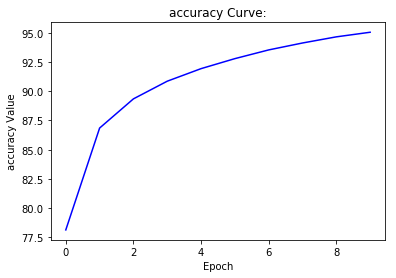

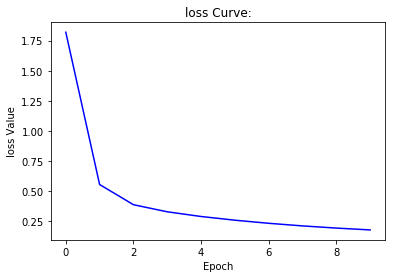

In [58]:
# TODO
show_curve(train_accs, 'accuracy')
show_curve(train_losses, 'loss')
# 3.1 show_curve

In [61]:
# TODO
batch_size = 128 # batch size is 128
n_epochs = 5 # train for 5 epochs
learning_rate = 0.5 # learning rate is 0.01
input_size = 28*28 # input image has size 28x28
hidden_size = 100 # hidden neurons is 100 for each layer
output_size = 10 # classes of prediction
l2_norm = 0 # not to use l2 penalty
dropout = False # not to use
get_grad = False # not to obtain grad

# declare a model
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_norm) 

train_accs, train_losses = fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, get_grad)
# 3.2 Train

Epoch: 1/5. Train set: Average loss: 0.4149, Accuracy: 92.2667
Epoch: 1/5. Validation set: Average loss: 22.8474, Accuracy: 91.9700
Epoch: 2/5. Train set: Average loss: 0.1332, Accuracy: 96.9450
Epoch: 2/5. Validation set: Average loss: 9.7631, Accuracy: 96.2600
Epoch: 3/5. Train set: Average loss: 0.0883, Accuracy: 97.5167
Epoch: 3/5. Validation set: Average loss: 8.8298, Accuracy: 96.6400
Epoch: 4/5. Train set: Average loss: 0.0669, Accuracy: 98.0983
Epoch: 4/5. Validation set: Average loss: 8.1344, Accuracy: 97.1000
Epoch: 5/5. Train set: Average loss: 0.0556, Accuracy: 98.1917
Epoch: 5/5. Validation set: Average loss: 8.3008, Accuracy: 97.0000


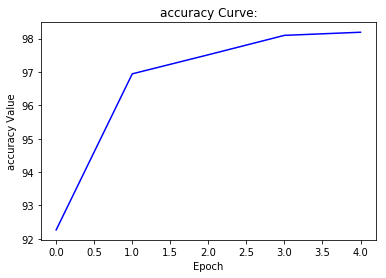

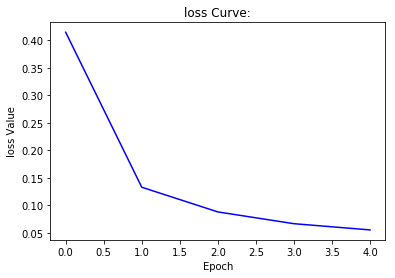

In [62]:
# TODO
show_curve(train_accs, 'accuracy')
show_curve(train_losses, 'loss')
# 3.2 show_curve

### 3.4 save model 
Pytorch provide two kinds of method to save model. We recommmend the method which only saves parameters. Because it's more feasible and dont' rely on fixed model. 

When saving parameters, we not only save **learnable parameters in model**, but also **learnable parameters in optimizer**. 

A common PyTorch convention is to save models using either a .pt or .pth file extension.

Read more abount save load from this [link](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [23]:
# show parameters in model

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("\nOptimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
hidden1.weight 	 torch.Size([100, 784])
hidden1.bias 	 torch.Size([100])
hidden2.weight 	 torch.Size([100, 100])
hidden2.bias 	 torch.Size([100])
hidden3.weight 	 torch.Size([100, 100])
hidden3.bias 	 torch.Size([100])
classification_layer.weight 	 torch.Size([10, 100])
classification_layer.bias 	 torch.Size([10])
hidden1_bn.weight 	 torch.Size([100])
hidden1_bn.bias 	 torch.Size([100])
hidden1_bn.running_mean 	 torch.Size([100])
hidden1_bn.running_var 	 torch.Size([100])
hidden1_bn.num_batches_tracked 	 torch.Size([])
hidden2_bn.weight 	 torch.Size([100])
hidden2_bn.bias 	 torch.Size([100])
hidden2_bn.running_mean 	 torch.Size([100])
hidden2_bn.running_var 	 torch.Size([100])
hidden2_bn.num_batches_tracked 	 torch.Size([])
hidden3_bn.weight 	 torch.Size([100])
hidden3_bn.bias 	 torch.Size([100])
hidden3_bn.running_mean 	 torch.Size([100])
hidden3_bn.running_var 	 torch.Size([100])
hidden3_bn.num_batches_tracked 	 torch.Size([])

Optimizer's state_dict:
state 	 {}
p

In [24]:
# save model

save_path = './model.pt'
torch.save(model.state_dict(), save_path)

In [25]:
# load parameters from files
saved_parametes = torch.load(save_path)
print(saved_parametes)

OrderedDict([('hidden1.weight', tensor([[ 0.0139,  0.0066,  0.0085,  ..., -0.0199, -0.0224, -0.0175],
        [-0.0203,  0.0124, -0.0012,  ..., -0.0191,  0.0124,  0.0150],
        [ 0.0166, -0.0257,  0.0184,  ..., -0.0165,  0.0065,  0.0083],
        ...,
        [-0.0289, -0.0002, -0.0065,  ...,  0.0056,  0.0075,  0.0073],
        [ 0.0073, -0.0034,  0.0260,  ..., -0.0085, -0.0055, -0.0162],
        [-0.0210,  0.0303,  0.0337,  ...,  0.0037,  0.0090, -0.0048]])), ('hidden1.bias', tensor([-0.0169, -0.0058, -0.0231,  0.0056,  0.0119, -0.0155, -0.0317,  0.0118,
         0.0043, -0.0130, -0.0190, -0.0158, -0.0195,  0.0144,  0.0004,  0.0280,
         0.0310,  0.0314, -0.0205,  0.0046,  0.0290, -0.0115,  0.0157, -0.0232,
        -0.0264, -0.0119, -0.0004, -0.0049, -0.0293,  0.0046, -0.0204, -0.0091,
        -0.0352, -0.0209,  0.0324, -0.0187, -0.0051, -0.0151, -0.0318, -0.0271,
         0.0061, -0.0004,  0.0039, -0.0274, -0.0014,  0.0081,  0.0268, -0.0111,
         0.0221,  0.0297, -0.0294, 

In [26]:
# initailze model by saved parameters
new_model = FeedForwardNeuralNetwork(input_size, hidden_size, output_size)
new_model.load_state_dict(saved_parametes)

## 作业 4
使用 test_epoch 函数，预测new_model在test_loader上的accuracy和loss

In [70]:
# TODO

# test your model prediction performance

new_test_loss, new_test_accuracy = evaluate(test_loader, new_model, loss_fn)
message = 'Average loss: {:.4f}, Accuracy: {:.4f}'.format(new_test_loss, new_test_accuracy)
print(message)

Average loss: 8.3008, Accuracy: 97.0000


## 4. Training Advanced

### 4.1 l2_norm
we could minimize the regularization term below by use $weight\_decay$ in **SGD optimizer**
\begin{equation}
    L\_norm =  {\sum_{i=1}^{m}{\theta_{i}^{2}}}
\end{equation}


set l2_norm=0.01, let's train and see

In [40]:
### Hyper parameters
batch_size = 128
n_epochs = 5
learning_rate = 0.01
input_size = 28*28
hidden_size = 100
output_size = 10
l2_norm = 0.01 # use l2 penalty
get_grad = False

# declare a model
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_norm) 

In [41]:
train_accs, train_losses = fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, get_grad)

Epoch: 1/5. Train set: Average loss: 1.9009, Accuracy: 74.3017
Epoch: 1/5. Validation set: Average loss: 74.4788, Accuracy: 74.6000
Epoch: 2/5. Train set: Average loss: 0.6102, Accuracy: 87.1717
Epoch: 2/5. Validation set: Average loss: 34.3180, Accuracy: 87.7700
Epoch: 3/5. Train set: Average loss: 0.3998, Accuracy: 89.2317
Epoch: 3/5. Validation set: Average loss: 28.3469, Accuracy: 89.4900
Epoch: 4/5. Train set: Average loss: 0.3501, Accuracy: 90.2517
Epoch: 4/5. Validation set: Average loss: 25.7806, Accuracy: 90.4200
Epoch: 5/5. Train set: Average loss: 0.3222, Accuracy: 90.9783
Epoch: 5/5. Validation set: Average loss: 23.9897, Accuracy: 91.0600


# 作业 5 
思考正则项在loss中占比的影响。使用 l2_norm = 1, 训练模型

Hints: 因为jupyter对变量有上下文关系，模型，优化器需要重新声明。可以使用以下代码进行重新定义模型和优化器。注意到此处用的是默认初始化。

In [72]:
# TODO

### Hyper parameters
batch_size = 128
n_epochs = 5
learning_rate = 0.01
input_size = 28*28
hidden_size = 100
output_size = 10
l2_norm = 1 # use l2 penalty
get_grad = False

# declare a model
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_norm)

In [73]:
# TODO
train_accs, train_losses = fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, get_grad)
# Train

Epoch: 1/5. Train set: Average loss: 2.3072, Accuracy: 11.2367
Epoch: 1/5. Validation set: Average loss: 181.8871, Accuracy: 11.3500
Epoch: 2/5. Train set: Average loss: 2.3073, Accuracy: 11.2367
Epoch: 2/5. Validation set: Average loss: 181.8870, Accuracy: 11.3500
Epoch: 3/5. Train set: Average loss: 2.3073, Accuracy: 11.2367
Epoch: 3/5. Validation set: Average loss: 181.8871, Accuracy: 11.3500
Epoch: 4/5. Train set: Average loss: 2.3073, Accuracy: 11.2367
Epoch: 4/5. Validation set: Average loss: 181.8871, Accuracy: 11.3500
Epoch: 5/5. Train set: Average loss: 2.3073, Accuracy: 11.2367
Epoch: 5/5. Validation set: Average loss: 181.8871, Accuracy: 11.3500


### 4.2 dropout
During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution. 

Each channel will be zeroed out independently on every forward call.

Hints: 因为jupyter对变量有上下文关系，模型，优化器需要重新声明。可以使用以下代码进行重新定义模型和优化器。注意到此处用的是默认初始化。

In [44]:
### Hyper parameters
batch_size = 128
n_epochs = 5
learning_rate = 0.01
input_size = 28*28
hidden_size = 100
output_size = 10
l2_norm = 0 # without using l2 penalty
get_grad = False

# declare a model
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_norm) 

In [45]:
# Set dropout to True and probability = 0.5
model.set_use_dropout(True)

In [46]:
train_accs, train_losses = fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, get_grad)

Epoch: 1/5. Train set: Average loss: 1.8824, Accuracy: 80.4967
Epoch: 1/5. Validation set: Average loss: 69.8040, Accuracy: 81.0000
Epoch: 2/5. Train set: Average loss: 0.7348, Accuracy: 87.4400
Epoch: 2/5. Validation set: Average loss: 33.8798, Accuracy: 87.6500
Epoch: 3/5. Train set: Average loss: 0.5086, Accuracy: 89.5917
Epoch: 3/5. Validation set: Average loss: 27.1355, Accuracy: 89.5500
Epoch: 4/5. Train set: Average loss: 0.4285, Accuracy: 90.8233
Epoch: 4/5. Validation set: Average loss: 23.7725, Accuracy: 90.8500
Epoch: 5/5. Train set: Average loss: 0.3815, Accuracy: 91.8033
Epoch: 5/5. Validation set: Average loss: 21.2870, Accuracy: 91.8900


### 4.3 batch_normalization
Batch normalization is a technique for improving the performance and stability of artificial neural networks

\begin{equation}
    y=\frac{x-E[x]}{\sqrt{Var[x]+\epsilon}} * \gamma + \beta, 
\end{equation}

$\gamma$ and $\beta$ are learnable parameters

Hints: 因为jupyter对变量有上下文关系，模型，优化器需要重新声明。可以使用以下代码进行重新定义模型和优化器。注意到此处用的是默认初始化。

In [47]:
### Hyper parameters
batch_size = 128
n_epochs = 5
learning_rate = 0.01
input_size = 28*28
hidden_size = 100
output_size = 10
l2_norm = 0 # without using l2 penalty
get_grad = False

# declare a model
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_norm) 

In [48]:
model.set_use_bn(True)

In [49]:
model.use_bn

True

In [50]:
train_accs, train_losses = fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, get_grad)

Epoch: 1/5. Train set: Average loss: 1.0694, Accuracy: 91.1317
Epoch: 1/5. Validation set: Average loss: 35.9896, Accuracy: 91.4500
Epoch: 2/5. Train set: Average loss: 0.3393, Accuracy: 94.3667
Epoch: 2/5. Validation set: Average loss: 19.5889, Accuracy: 94.1300
Epoch: 3/5. Train set: Average loss: 0.2161, Accuracy: 95.6933
Epoch: 3/5. Validation set: Average loss: 14.6173, Accuracy: 95.3200
Epoch: 4/5. Train set: Average loss: 0.1645, Accuracy: 96.5617
Epoch: 4/5. Validation set: Average loss: 12.0746, Accuracy: 95.8500
Epoch: 5/5. Train set: Average loss: 0.1339, Accuracy: 97.1417
Epoch: 5/5. Validation set: Average loss: 10.6426, Accuracy: 96.2500


### 4.4 data augmentation
data augmentation can be more complicated to gain a better generalization on test dataset

In [75]:
# only add random horizontal flip
train_transform_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Convert a PIL Image or numpy.ndarray to tensor.
    # Normalize a tensor image with mean and standard deviation
    transforms.Normalize((0.1307,), (0.3081,))
])

# only add random crop
train_transform_2 = transforms.Compose([
    transforms.RandomCrop(size=[28,28], padding=4),
    transforms.ToTensor(), # Convert a PIL Image or numpy.ndarray to tensor.
    # Normalize a tensor image with mean and standard deviation
    transforms.Normalize((0.1307,), (0.3081,))
])

# add random horizontal flip and random crop
train_transform_3 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=[28,28], padding=4),
    transforms.ToTensor(), # Convert a PIL Image or numpy.ndarray to tensor.
    # Normalize a tensor image with mean and standard deviation
    transforms.Normalize((0.1307,), (0.3081,))
])

In [52]:
# reload train_loader using trans

train_dataset_1 = torchvision.datasets.MNIST(root='./data', 
                            train=True, 
                            transform=train_transform_1,
                            download=False)

train_loader_1 = torch.utils.data.DataLoader(dataset=train_dataset_1, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [53]:
print(train_dataset_1)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None


In [54]:
### Hyper parameters
batch_size = 128
n_epochs = 5
learning_rate = 0.01
input_size = 28*28
hidden_size = 100
output_size = 10
l2_norm = 0 # without using l2 penalty
get_grad = False

# declare a model
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_norm) 

In [55]:
train_accs, train_losses = fit(train_loader_1, test_loader, model, loss_fn, optimizer, n_epochs, get_grad)

Epoch: 1/5. Train set: Average loss: 2.0063, Accuracy: 68.9483
Epoch: 1/5. Validation set: Average loss: 91.0255, Accuracy: 69.8400
Epoch: 2/5. Train set: Average loss: 0.7965, Accuracy: 79.6317
Epoch: 2/5. Validation set: Average loss: 49.2182, Accuracy: 80.1000
Epoch: 3/5. Train set: Average loss: 0.5844, Accuracy: 82.9250
Epoch: 3/5. Validation set: Average loss: 40.5368, Accuracy: 83.4900
Epoch: 4/5. Train set: Average loss: 0.5082, Accuracy: 85.2550
Epoch: 4/5. Validation set: Average loss: 35.7995, Accuracy: 85.8400
Epoch: 5/5. Train set: Average loss: 0.4541, Accuracy: 86.4417
Epoch: 5/5. Validation set: Average loss: 32.2371, Accuracy: 87.0600


## 作业 6
使用提供的train_transform_2, train_transform_3，重新加载train_loader，并且使用fit进行训练

Hints: 因为jupyter对变量有上下文关系，模型，优化器需要重新声明。注意到此处用的是默认初始化。

In [76]:
# TODO
### Hyper parameters
batch_size = 128
n_epochs = 5
learning_rate = 0.01
input_size = 28*28
hidden_size = 100
output_size = 10
l2_norm = 0 # without using l2 penalty
get_grad = False

# declare a model
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_norm) 

# reload train_loader using trans

train_dataset_2 = torchvision.datasets.MNIST(root='./data', 
                            train=True, 
                            transform=train_transform_2,
                            download=False)

train_loader_2 = torch.utils.data.DataLoader(dataset=train_dataset_2, 
                                           batch_size=batch_size, 
                                           shuffle=True)

train_accs, train_losses = fit(train_loader_2, test_loader, model, loss_fn, optimizer, n_epochs, get_grad)

# train_transform_2

Epoch: 1/5. Train set: Average loss: 2.2798, Accuracy: 26.9050
Epoch: 1/5. Validation set: Average loss: 171.4213, Accuracy: 32.3400
Epoch: 2/5. Train set: Average loss: 1.9973, Accuracy: 40.0700
Epoch: 2/5. Validation set: Average loss: 115.7446, Accuracy: 56.2900
Epoch: 3/5. Train set: Average loss: 1.5243, Accuracy: 55.0117
Epoch: 3/5. Validation set: Average loss: 81.8297, Accuracy: 68.9600
Epoch: 4/5. Train set: Average loss: 1.1292, Accuracy: 70.3617
Epoch: 4/5. Validation set: Average loss: 61.4953, Accuracy: 78.6700
Epoch: 5/5. Train set: Average loss: 0.8388, Accuracy: 77.9417
Epoch: 5/5. Validation set: Average loss: 46.9672, Accuracy: 83.3400


In [77]:
# TODO

### Hyper parameters
batch_size = 128
n_epochs = 5
learning_rate = 0.01
input_size = 28*28
hidden_size = 100
output_size = 10
l2_norm = 0 # without using l2 penalty
get_grad = False

# declare a model
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_norm) 

# reload train_loader using trans

train_dataset_3 = torchvision.datasets.MNIST(root='./data', 
                            train=True, 
                            transform=train_transform_3,
                            download=False)

train_loader_3 = torch.utils.data.DataLoader(dataset=train_dataset_3, 
                                           batch_size=batch_size, 
                                           shuffle=True)

train_accs, train_losses = fit(train_loader_3, test_loader, model, loss_fn, optimizer, n_epochs, get_grad)

# train_transform_3

Epoch: 1/5. Train set: Average loss: 2.2968, Accuracy: 21.7617
Epoch: 1/5. Validation set: Average loss: 178.0336, Accuracy: 26.7000
Epoch: 2/5. Train set: Average loss: 2.1886, Accuracy: 30.6783
Epoch: 2/5. Validation set: Average loss: 152.3037, Accuracy: 40.1900
Epoch: 3/5. Train set: Average loss: 1.8450, Accuracy: 41.3617
Epoch: 3/5. Validation set: Average loss: 111.4603, Accuracy: 56.9500
Epoch: 4/5. Train set: Average loss: 1.5071, Accuracy: 53.5100
Epoch: 4/5. Validation set: Average loss: 86.8512, Accuracy: 67.6000
Epoch: 5/5. Train set: Average loss: 1.1898, Accuracy: 65.5283
Epoch: 5/5. Validation set: Average loss: 70.3585, Accuracy: 73.6800


## 5. Visualizatio of training and validation phase
We could use tensorboard to visualize our training and test phase.
You could find example [here](https://github.com/lanpa/tensorboardX)

## 6. Gradient explosion and vanishing
We have embedded code which shows grad for hidden2 and hidden3 layer. By observing their grad changes, we can 
see whether gradient is normal or not.

For plot grad changes, you need to **set get_grad=True** in **fit function**

In [22]:
### Hyper parameters
batch_size = 128
n_epochs = 15
learning_rate = 0.01
input_size = 28*28
hidden_size = 100
output_size = 10
l2_norm = 0 # use l2 penalty
get_grad = True

# declare a model
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_norm) 

Epoch: 1/15. Train set: Average loss: 1.8550, Accuracy: 78.3233
Epoch: 1/15. Validation set: Average loss: 67.1493, Accuracy: 79.1100
Epoch: 2/15. Train set: Average loss: 0.5500, Accuracy: 87.2000
Epoch: 2/15. Validation set: Average loss: 32.6792, Accuracy: 87.3500
Epoch: 3/15. Train set: Average loss: 0.3757, Accuracy: 89.4550
Epoch: 3/15. Validation set: Average loss: 26.8909, Accuracy: 89.6300
Epoch: 4/15. Train set: Average loss: 0.3227, Accuracy: 90.7600
Epoch: 4/15. Validation set: Average loss: 23.6372, Accuracy: 90.8100
Epoch: 5/15. Train set: Average loss: 0.2878, Accuracy: 91.7650
Epoch: 5/15. Validation set: Average loss: 21.2775, Accuracy: 91.6300
Epoch: 6/15. Train set: Average loss: 0.2599, Accuracy: 92.5317
Epoch: 6/15. Validation set: Average loss: 19.3423, Accuracy: 92.4600
Epoch: 7/15. Train set: Average loss: 0.2366, Accuracy: 93.2067
Epoch: 7/15. Validation set: Average loss: 17.7432, Accuracy: 93.2300
Epoch: 8/15. Train set: Average loss: 0.2167, Accuracy: 93.808

([78.32333333333334,
  87.2,
  89.455,
  90.76,
  91.765,
  92.53166666666667,
  93.20666666666666,
  93.80833333333334,
  94.32166666666667,
  94.76,
  95.12,
  95.4,
  95.71833333333333,
  95.97166666666666,
  96.22],
 [1.8550415935679379,
  0.5500268716460619,
  0.3757120491698002,
  0.3226871870489966,
  0.2877719647083909,
  0.25993374993021673,
  0.23659020472063214,
  0.2166887305947578,
  0.19964969689106074,
  0.18499633120611692,
  0.17221029536623475,
  0.16093775283338296,
  0.15086411013721657,
  0.1417956079603133,
  0.13365019279985857])

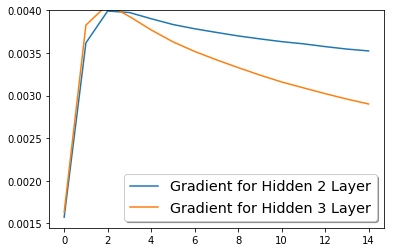

In [23]:
fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, get_grad)

### 6.1.1 Gradient Vanishing

Set learning=e-10

In [27]:
### Hyper parameters
batch_size = 128
n_epochs = 15
learning_rate = 1e-10
input_size = 28*28
hidden_size = 100
output_size = 10
l2_norm = 0 # use l2 penalty
get_grad = True

# declare a model
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_norm) 

Epoch: 1/15. Train set: Average loss: 2.3080, Accuracy: 12.1217
Epoch: 1/15. Validation set: Average loss: 182.0099, Accuracy: 12.0900
Epoch: 2/15. Train set: Average loss: 2.3080, Accuracy: 12.1217
Epoch: 2/15. Validation set: Average loss: 182.0099, Accuracy: 12.0900
Epoch: 3/15. Train set: Average loss: 2.3080, Accuracy: 12.1217
Epoch: 3/15. Validation set: Average loss: 182.0099, Accuracy: 12.0900
Epoch: 4/15. Train set: Average loss: 2.3080, Accuracy: 12.1217
Epoch: 4/15. Validation set: Average loss: 182.0099, Accuracy: 12.0900
Epoch: 5/15. Train set: Average loss: 2.3080, Accuracy: 12.1217
Epoch: 5/15. Validation set: Average loss: 182.0099, Accuracy: 12.0900
Epoch: 6/15. Train set: Average loss: 2.3080, Accuracy: 12.1217
Epoch: 6/15. Validation set: Average loss: 182.0099, Accuracy: 12.0900
Epoch: 7/15. Train set: Average loss: 2.3080, Accuracy: 12.1217
Epoch: 7/15. Validation set: Average loss: 182.0099, Accuracy: 12.0900
Epoch: 8/15. Train set: Average loss: 2.3080, Accuracy:

([12.121666666666666,
  12.121666666666666,
  12.121666666666666,
  12.121666666666666,
  12.121666666666666,
  12.121666666666666,
  12.121666666666666,
  12.121666666666666,
  12.121666666666666,
  12.121666666666666,
  12.121666666666666,
  12.121666666666666,
  12.121666666666666,
  12.121666666666666,
  12.121666666666666],
 [2.308037218375084,
  2.308037218375084,
  2.308037218375084,
  2.308037218375084,
  2.308037218375084,
  2.308037218375084,
  2.308037218375084,
  2.308037218375084,
  2.308037218375084,
  2.308037218375084,
  2.308037218375084,
  2.308037218375084,
  2.308037218375084,
  2.308037218375084,
  2.308037218375084])

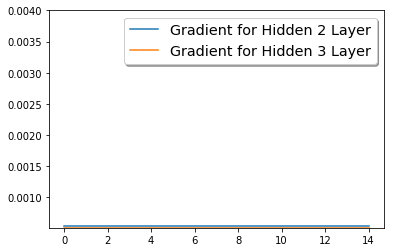

In [28]:
fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, get_grad=get_grad)

# 6.1.2 Gradient Explosion

#### 6.1.2.1 learning rate
set learning rate = 10

In [29]:
### Hyper parameters
batch_size = 128
n_epochs = 15
learning_rate = 10
input_size = 28*28
hidden_size = 100
output_size = 10
l2_norm = 0 # not to use l2 penalty
get_grad = True

# declare a model
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_norm) 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: overflow encountered in square
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: overflow encountered in square


Epoch: 1/15. Train set: Average loss: nan, Accuracy: 9.8717
Epoch: 1/15. Validation set: Average loss: nan, Accuracy: 9.8000
Epoch: 2/15. Train set: Average loss: nan, Accuracy: 9.8717
Epoch: 2/15. Validation set: Average loss: nan, Accuracy: 9.8000
Epoch: 3/15. Train set: Average loss: nan, Accuracy: 9.8717
Epoch: 3/15. Validation set: Average loss: nan, Accuracy: 9.8000
Epoch: 4/15. Train set: Average loss: nan, Accuracy: 9.8717
Epoch: 4/15. Validation set: Average loss: nan, Accuracy: 9.8000
Epoch: 5/15. Train set: Average loss: nan, Accuracy: 9.8717
Epoch: 5/15. Validation set: Average loss: nan, Accuracy: 9.8000
Epoch: 6/15. Train set: Average loss: nan, Accuracy: 9.8717
Epoch: 6/15. Validation set: Average loss: nan, Accuracy: 9.8000
Epoch: 7/15. Train set: Average loss: nan, Accuracy: 9.8717
Epoch: 7/15. Validation set: Average loss: nan, Accuracy: 9.8000
Epoch: 8/15. Train set: Average loss: nan, Accuracy: 9.8717
Epoch: 8/15. Validation set: Average loss: nan, Accuracy: 9.8000


([9.8716666666666661,
  9.8716666666666661,
  9.8716666666666661,
  9.8716666666666661,
  9.8716666666666661,
  9.8716666666666661,
  9.8716666666666661,
  9.8716666666666661,
  9.8716666666666661,
  9.8716666666666661,
  9.8716666666666661,
  9.8716666666666661,
  9.8716666666666661,
  9.8716666666666661,
  9.8716666666666661],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

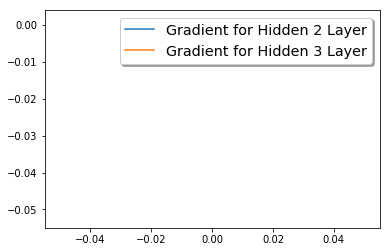

In [30]:
fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, get_grad=True)

#### 6.1.2.2 normalization for input data

#### 6.1.2.3 unsuitable weight initialization

In [64]:
### Hyper parameters
batch_size = 128
n_epochs = 15
learning_rate = 1
input_size = 28*28
hidden_size = 100
output_size = 10
l2_norm = 0 # not to use l2 penalty
get_grad = True

# declare a model
model = FeedForwardNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# l2_norm can be done in SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_norm) 

In [65]:
# reset parameters as 10
def wrong_weight_bias_reset(model):
    """Using normalization with mean=0, std=1 to initialize model's parameter
    """
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # initialize linear layer with mean and std
            mean, std = 0, 1 
            
            # Initialization method
            torch.nn.init.normal_(m.weight, mean, std)
            torch.nn.init.normal_(m.bias, mean, std)

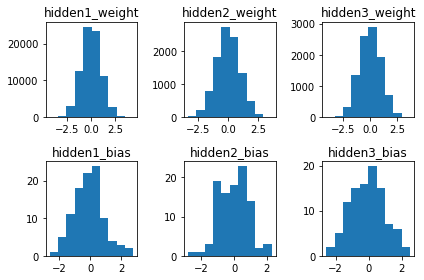

In [66]:
wrong_weight_bias_reset(model)
show_weight_bias(model)

/home/lincolnzjx/anaconda3/envs/Py36/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: overflow encountered in square
/home/lincolnzjx/anaconda3/envs/Py36/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: overflow encountered in square


Epoch: 1/15. Train set: Average loss: nan, Accuracy: 9.8717
Epoch: 1/15. Validation set: Average loss: nan, Accuracy: 9.8000
Epoch: 2/15. Train set: Average loss: nan, Accuracy: 9.8717
Epoch: 2/15. Validation set: Average loss: nan, Accuracy: 9.8000
Epoch: 3/15. Train set: Average loss: nan, Accuracy: 9.8717
Epoch: 3/15. Validation set: Average loss: nan, Accuracy: 9.8000
Epoch: 4/15. Train set: Average loss: nan, Accuracy: 9.8717
Epoch: 4/15. Validation set: Average loss: nan, Accuracy: 9.8000
Epoch: 5/15. Train set: Average loss: nan, Accuracy: 9.8717
Epoch: 5/15. Validation set: Average loss: nan, Accuracy: 9.8000
Epoch: 6/15. Train set: Average loss: nan, Accuracy: 9.8717
Epoch: 6/15. Validation set: Average loss: nan, Accuracy: 9.8000
Epoch: 7/15. Train set: Average loss: nan, Accuracy: 9.8717
Epoch: 7/15. Validation set: Average loss: nan, Accuracy: 9.8000
Epoch: 8/15. Train set: Average loss: nan, Accuracy: 9.8717
Epoch: 8/15. Validation set: Average loss: nan, Accuracy: 9.8000


([9.871666666666666,
  9.871666666666666,
  9.871666666666666,
  9.871666666666666,
  9.871666666666666,
  9.871666666666666,
  9.871666666666666,
  9.871666666666666,
  9.871666666666666,
  9.871666666666666,
  9.871666666666666,
  9.871666666666666,
  9.871666666666666,
  9.871666666666666,
  9.871666666666666],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

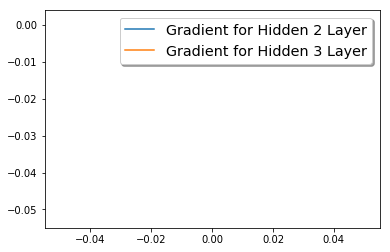

In [67]:
fit(train_loader, test_loader, model, loss_fn, optimizer, n_epochs, get_grad=True)


## References
1. [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
2. [Save Model and Load Model](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
3. [Visualize your training phase](https://github.com/lanpa/tensorboardX)
4. [Exploding and Vanishing Gradients](http://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/readings/L15%20Exploding%20and%20Vanishing%20Gradients.pdf)
5. [Gradient disappearance and gradient explosion in neural network training](https://bzdww.com/article/19659/)
6. [tensorboardX](https://github.com/lanpa/tensorboardX)
